#Chapter 3. Transformer Anatomy
In Chapter 2, we saw what it takes to fine-tune and evaluate a transformer. Now let’s take a look at how they work under the hood. In this chapter we’ll explore the main building blocks of transformer models and how to implement them using PyTorch. We’ll also provide guidance on how to do the same in TensorFlow. We’ll first focus on building the attention mechanism, and then add the bits and pieces necessary to make a transformer encoder work. We’ll also have a brief look at the architectural differences between the encoder and decoder modules. By the end of this chapter you will be able to implement a simple transformer model yourself!

While a deep technical understanding of the Transformer architecture is generally not necessary to use nlpt_pin01 Transformers and fine-tune models for your use case, it can be helpful for comprehending and navigating the limitations of transformers and using them in new domains.

This chapter also introduces a taxonomy of transformers to help you understand the zoo of models that have emerged in recent years. Before diving into the code, let’s start with an overview of the original architecture that kick-started the transformer revolution.

###The Transformer Architecture
As we saw in Chapter 1, the original Transformer is based on the encoder-decoder architecture that is widely used for tasks like machine translation, where a sequence of words is translated from one language to another. This architecture consists of two components:

###Encoder
Converts an input sequence of tokens into a sequence of embedding vectors, often called the hidden state or context

###Decoder
Uses the encoder’s hidden state to iteratively generate an output sequence of tokens, one token at a time

As illustrated in Figure 3-1, the encoder and decoder are themselves composed of several building blocks.

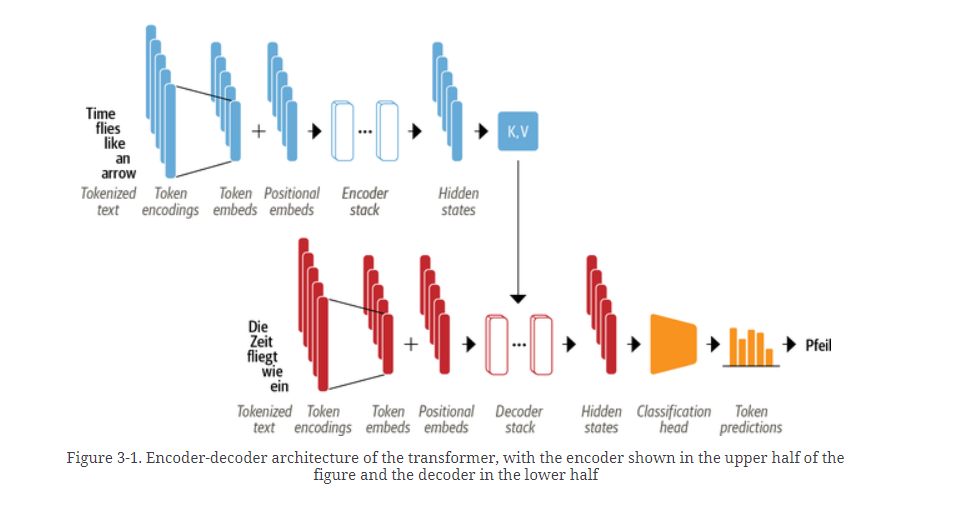

We’ll look at each of the components in detail shortly, but we can already see a few things in Figure 3-1 that characterize the Transformer architecture:

The input text is tokenized and converted to token embeddings using the techniques we encountered in Chapter 2. Since the attention mechanism is not aware of the relative positions of the tokens, we need a way to inject some information about token positions into the input to model the sequential nature of text. The token embeddings are thus combined with positional embeddings that contain positional information for each token.

The encoder is composed of a stack of encoder layers or “blocks,” which is analogous to stacking convolutional layers in computer vision. The same is true of the decoder, which has its own stack of decoder layers.

The encoder’s output is fed to each decoder layer, and the decoder then generates a prediction for the most probable next token in the sequence. The output of this step is then fed back into the decoder to generate the next token, and so on until a special end-of-sequence (EOS) token is reached. In the example from Figure 3-1, imagine the decoder has already predicted “Die” and “Zeit”. Now it gets these two as an input as well as all the encoder’s outputs to predict the next token, “fliegt”. In the next step the decoder gets “fliegt” as an additional input. We repeat the process until the decoder predicts the EOS token or we reached a maximum length.

The Transformer architecture was originally designed for sequence-to-sequence tasks like machine translation, but both the encoder and decoder blocks were soon adapted as standalone models. Although there are hundreds of different transformer models, most of them belong to one of three types:

##Encoder-only
These models convert an input sequence of text into a rich numerical representation that is well suited for tasks like text classification or named entity recognition. BERT and its variants, like RoBERTa and DistilBERT, belong to this class of architectures. The representation computed for a given token in this architecture depends both on the left (before the token) and the right (after the token) contexts. This is often called bidirectional attention.

##Decoder-only
Given a prompt of text like “Thanks for lunch, I had a…” these models will auto-complete the sequence by iteratively predicting the most probable next word. The family of GPT models belong to this class. The representation computed for a given token in this architecture depends only on the left context. This is often called causal or autoregressive attention.

##Encoder-decoder
These are used for modeling complex mappings from one sequence of text to another; they’re suitable for machine translation and summarization tasks. In addition to the Transformer architecture, which as we’ve seen combines an encoder and a decoder, the BART and T5 models belong to this class.

###NOTE
In reality, the distinction between applications for decoder-only versus encoder-only architectures is a bit blurry. For example, decoder-only models like those in the GPT family can be primed for tasks like translation that are conventionally thought of as sequence-to-sequence tasks. Similarly, encoder-only models like BERT can be applied to summarization tasks that are usually associated with encoder-decoder or decoder-only models.1

Now that you have a high-level understanding of the Transformer architecture, let’s take a closer look at the inner workings of the encoder.

The Encoder
As we saw earlier, the transformer’s encoder consists of many encoder layers stacked next to each other. As illustrated in Figure 3-2, each encoder layer receives a sequence of embeddings and feeds them through the following sublayers:

##A multi-head self-attention layer

A fully connected feed-forward layer that is applied to each input embedding

The output embeddings of each encoder layer have the same size as the inputs, and we’ll soon see that the main role of the encoder stack is to “update” the input embeddings to produce representations that encode some contextual information in the sequence. For example, the word “apple” will be updated to be more “company-like” and less “fruit-like” if the words “keynote” or “phone” are close to it.

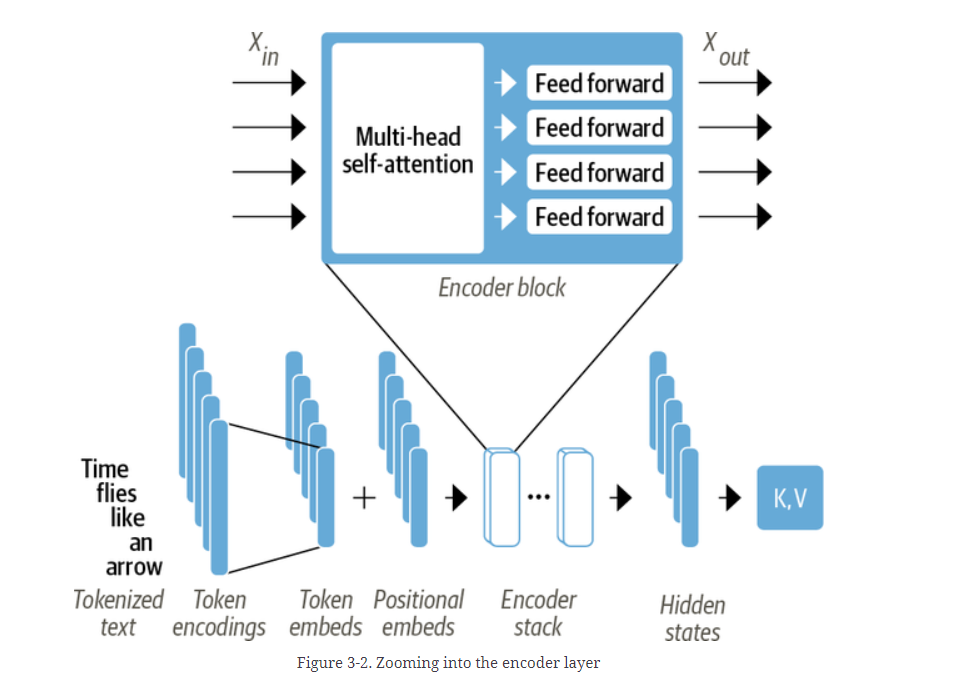

Each of these sublayers also uses skip connections and layer normalization, which are standard tricks to train deep neural networks effectively. But to truly understand what makes a transformer work, we have to go deeper. Let’s start with the most important building block: the self-attention layer.

Self-Attention
As we discussed in Chapter 1, attention is a mechanism that allows neural networks to assign a different amount of weight or “attention” to each element in a sequence. For text sequences, the elements are token embeddings like the ones we encountered in Chapter 2, where each token is mapped to a vector of some fixed dimension. For example, in BERT each token is represented as a 768-dimensional vector. The “self” part of self-attention refers to the fact that these weights are computed for all hidden states in the same set—for example, all the hidden states of the encoder. By contrast, the attention mechanism associated with recurrent models involves computing the relevance of each encoder hidden state to the decoder hidden state at a given decoding timestep.



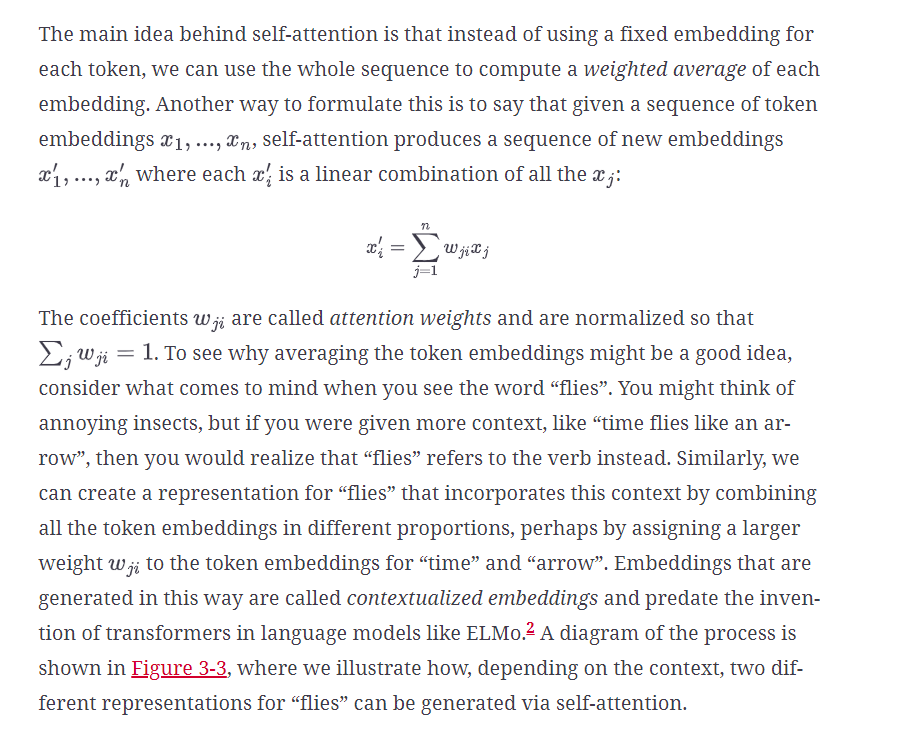

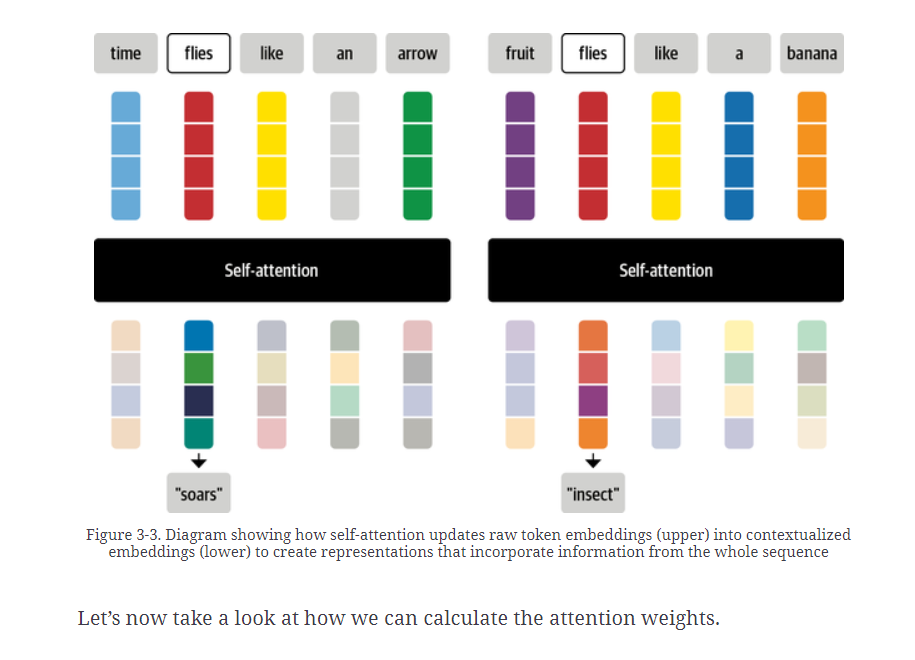

Scaled dot-product attention
There are several ways to implement a self-attention layer, but the most common one is scaled dot-product attention, from the paper introducing the Transformer architecture.3 There are four main steps required to implement this mechanism:

Project each token embedding into three vectors called query, key, and value.

Compute attention scores. We determine how much the query and key vectors relate to each other using a similarity function. As the name suggests, the similarity function for scaled dot-product attention is the dot product, computed efficiently using matrix multiplication of the embeddings. Queries and keys that are similar will have a large dot product, while those that don’t share much in common will have little to no overlap. The outputs from this step are called the attention scores, and for a sequence with n input tokens there is a corresponding  matrix of attention scores.

Compute attention weights. Dot products can in general produce arbitrarily large numbers, which can destabilize the training process. To handle this, the attention scores are first multiplied by a scaling factor to normalize their variance and then normalized with a softmax to ensure all the column values sum to 1. The resulting n × n matrix now contains all the attention weights, wji.

Update the token embeddings. Once the attention weights are computed, we multiply them by the value vector  v1,.....vn, to obtain an updated representation for embedding 

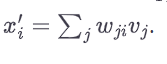

We can visualize how the attention weights are calculated with a nifty library called BertViz for Jupyter. This library provides several functions that can be used to visualize different aspects of attention in transformer models. To visualize the attention weights, we can use the neuron_view module, which traces the computation of the weights to show how the query and key vectors are combined to produce the final weight. Since BertViz needs to tap into the attention layers of the model, we’ll instantiate our BERT checkpoint with the model class from BertViz and then use the show() function to generate the interactive visualization for a specific encoder layer and attention head. Note that you need to click the “+” on the left to activate the attention visualization:

In [1]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 27.5 MB/s 
     |████████████████████████████████| 6.5 MB 41.4 MB/s 
     |████████████████████████████████| 67 kB 4.2 MB/s 
     |████████████████████████████████| 596 kB 51.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/token.
        (Deprecated, will be removed in v0.3.0) To login with username and password instead, interrupt with Ctrl+C.
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine

In [3]:
!pip install bertviz

     |████████████████████████████████| 155 kB 5.2 MB/s 
     |████████████████████████████████| 132 kB 40.9 MB/s 
     |████████████████████████████████| 1.2 MB 33.4 MB/s 
     |████████████████████████████████| 79 kB 7.4 MB/s 
     |████████████████████████████████| 8.6 MB 30.7 MB/s 
     |████████████████████████████████| 138 kB 35.8 MB/s 
     |████████████████████████████████| 127 kB 37.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
!pip install urllib3

In [5]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text = "time flies like an arrow"
show(model, "bert", tokenizer, text, display_mode="light", layer=0, head=8)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

100%|██████████| 440473133/440473133 [00:20<00:00, 21395705.31B/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

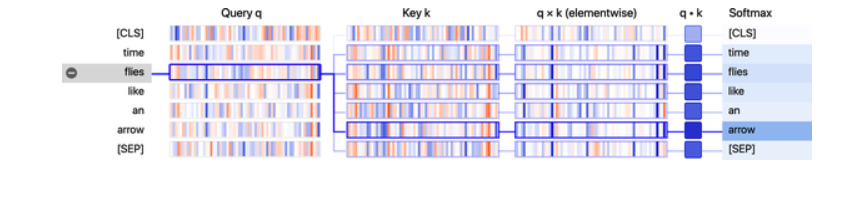

From the visualization, we can see the values of the query and key vectors are represented as vertical bands, where the intensity of each band corresponds to the magnitude. The connecting lines are weighted according to the attention between the tokens, and we can see that the query vector for “flies” has the strongest overlap with the key vector for “arrow”.

#DEMYSTIFYING QUERIES, KEYS, AND VALUES
The notion of query, key, and value vectors may seem a bit cryptic the first time you encounter them. Their names were inspired by information retrieval systems, but we can motivate their meaning with a simple analogy. Imagine that you’re at the supermarket buying all the ingredients you need for your dinner. You have the dish’s recipe, and each of the required ingredients can be thought of as a query. As you scan the shelves, you look at the labels (keys) and check whether they match an ingredient on your list (similarity function). If you have a match, then you take the item (value) from the shelf.

In this analogy, you only get one grocery item for every label that matches the ingredient. Self-attention is a more abstract and “smooth” version of this: every label in the supermarket matches the ingredient to the extent to which each key matches the query. So if your list includes a dozen eggs, then you might end up grabbing 10 eggs, an omelette, and a chicken wing.

Let’s take a look at this process in more detail by implementing the diagram of operations to compute scaled dot-product attention, as shown in Figure 3-4.

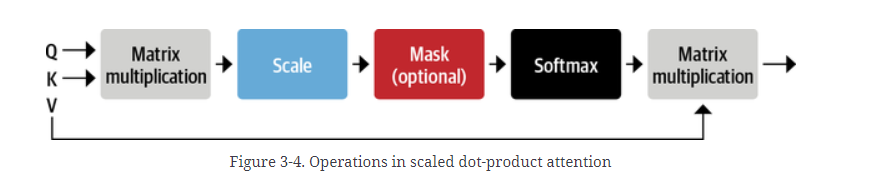

We will use PyTorch to implement the Transformer architecture in this chapter, but the steps in TensorFlow are analogous. We provide a mapping between the most important functions in the two frameworks in Table 3-1.

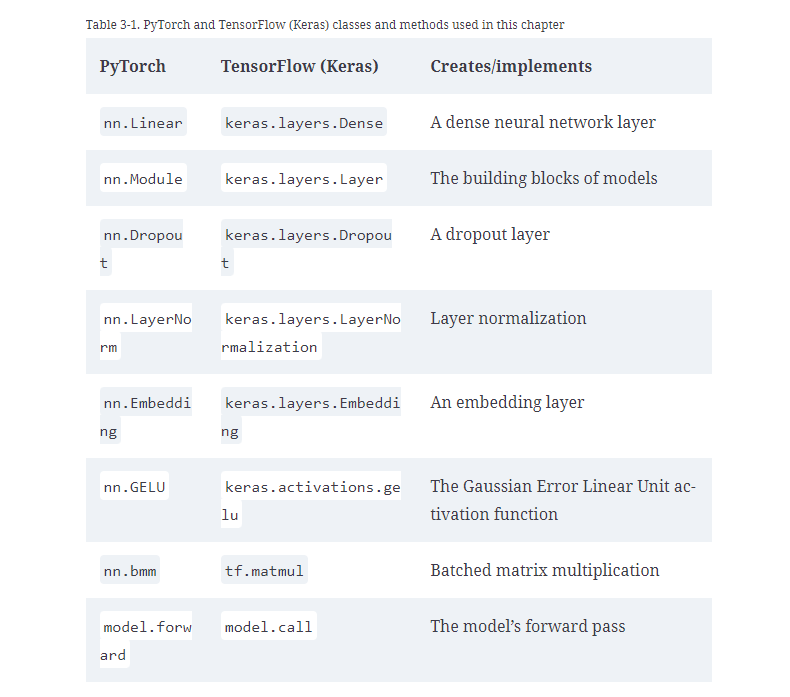

The first thing we need to do is tokenize the text, so let’s use our tokenizer to extract the input IDs:

In [6]:
inputs = tokenizer(text, return_tensors="pt", add_special_tokens=False)
inputs.input_ids

tensor([[ 2051, 10029,  2066,  2019,  8612]])

As we saw in Chapter 2, each token in the sentence has been mapped to a unique ID in the tokenizer’s vocabulary. To keep things simple, we’ve also excluded the [CLS] and [SEP] tokens by setting add_special_tokens=False. Next, we need to create some dense embeddings. Dense in this context means that each entry in the embeddings contains a nonzero value. In contrast, the one-hot encodings we saw in Chapter 2 are sparse, since all entries except one are zero. In PyTorch, we can do this by using a torch.nn.Embedding layer that acts as a lookup table for each input ID:

In [8]:
from torch import nn
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

Embedding(30522, 768)

Here we’ve used the AutoConfig class to load the config.json file associated with the bert-base-uncased checkpoint. In nlpt_pin01 Transformers, every checkpoint is assigned a configuration file that specifies various hyperparameters like vocab_size and hidden_size, which in our example shows us that each input ID will be mapped to one of the 30,522 embedding vectors stored in nn.Embedding, each with a size of 768. The AutoConfig class also stores additional metadata, such as the label names, which are used to format the model’s predictions.

Note that the token embeddings at this point are independent of their context. This means that homonyms (words that have the same spelling but different meaning), like “flies” in the previous example, have the same representation. The role of the subsequent attention layers will be to mix these token embeddings to disambiguate and inform the representation of each token with the content of its context.

Now that we have our lookup table, we can generate the embeddings by feeding in the input IDs:

In [9]:
inputs_embeds = token_emb(inputs.input_ids)
inputs_embeds.size()

torch.Size([1, 5, 768])

This has given us a tensor of shape [batch_size, seq_len, hidden_dim], just like we saw in Chapter 2. We’ll postpone the positional encodings, so the next step is to create the query, key, and value vectors and calculate the attention scores using the dot product as the similarity function:

In [11]:
import torch
from math import sqrt

query = key = value = inputs_embeds
dim_k = key.size(-1)
scores = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)
scores.size()

torch.Size([1, 5, 5])

This has created a  matrix of attention scores per sample in the batch. We’ll see later that the query, key, and value vectors are generated by applying independent weight matrices  to the embeddings, but for now we’ve kept them equal for simplicity. In scaled dot-product attention, the dot products are scaled by the size of the embedding vectors so that we don’t get too many large numbers during training that can cause the softmax we will apply next to saturate.

#NOTE
The torch.bmm() function performs a batch matrix-matrix product that simplifies the computation of the attention scores where the query and key vectors have the shape [batch_size, seq_len, hidden_dim]. If we ignored the batch dimension we could calculate the dot product between each query and key vector by simply transposing the key tensor to have the shape [hidden_dim, seq_len] and then using the matrix product to collect all the dot products in a [seq_len, seq_len] matrix. Since we want to do this for all sequences in the batch independently, we use torch.bmm(), which takes two batches of matrices and multiplies each matrix from the first batch with the corresponding matrix in the second batch.

Let’s apply the softmax now:

In [12]:
import torch.nn.functional as F

weights = F.softmax(scores, dim=-1)
weights.sum(dim=-1)

tensor([[1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)

The final step is to multiply the attention weights by the values:

In [13]:
attn_outputs = torch.bmm(weights, value)
attn_outputs.shape

torch.Size([1, 5, 768])

And that’s it—we’ve gone through all the steps to implement a simplified form of self-attention! Notice that the whole process is just two matrix multiplications and a softmax, so you can think of “self-attention” as just a fancy form of averaging.

Let’s wrap these steps into a function that we can use later:

In [14]:
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)

Our attention mechanism with equal query and key vectors will assign a very large score to identical words in the context, and in particular to the current word itself: the dot product of a query with itself is always 1. But in practice, the meaning of a word will be better informed by complementary words in the context than by identical words—for example, the meaning of “flies” is better defined by incorporating information from “time” and “arrow” than by another mention of “flies”. How can we promote this behavior?

Let’s allow the model to create a different set of vectors for the query, key, and value of a token by using three different linear projections to project our initial token vector into three different spaces.

#Multi-headed attention
In our simple example, we only used the embeddings “as is” to compute the attention scores and weights, but that’s far from the whole story. In practice, the self-attention layer applies three independent linear transformations to each embedding to generate the query, key, and value vectors. These transformations project the embeddings and each projection carries its own set of learnable parameters, which allows the self-attention layer to focus on different semantic aspects of the sequence.

It also turns out to be beneficial to have multiple sets of linear projections, each one representing a so-called attention head. The resulting multi-head attention layer is illustrated in Figure 3-5. But why do we need more than one attention head? The reason is that the softmax of one head tends to focus on mostly one aspect of similarity. Having several heads allows the model to focus on several aspects at once. For instance, one head can focus on subject-verb interaction, whereas another finds nearby adjectives. Obviously we don’t handcraft these relations into the model, and they are fully learned from the data. If you are familiar with computer vision models you might see the resemblance to filters in convolutional neural networks, where one filter can be responsible for detecting faces and another one finds wheels of cars in images.

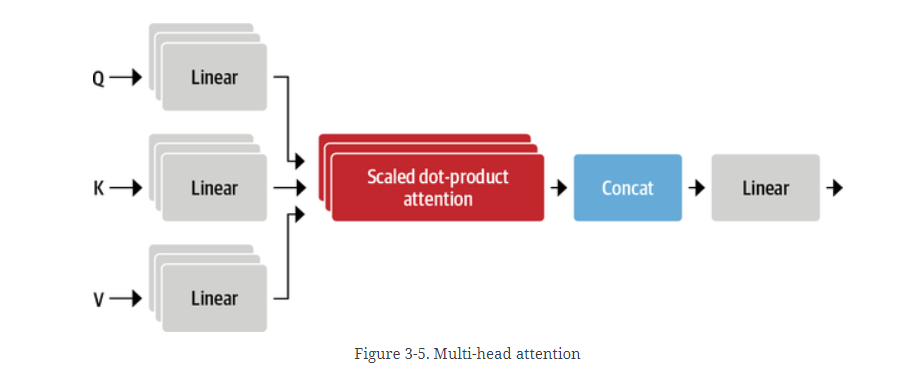

Let’s implement this layer by first coding up a single attention head:

In [16]:
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state))
        return attn_outputs

Here we’ve initialized three independent linear layers that apply matrix multiplication to the embedding vectors to produce tensors of shape [batch_size, seq_len, head_dim], where head_dim is the number of dimensions we are projecting into. Although head_dim does not have to be smaller than the number of embedding dimensions of the tokens (embed_dim), in practice it is chosen to be a multiple of embed_dim so that the computation across each head is constant. For example, BERT has 12 attention heads, so the dimension of each head is 768/12=64

Now that we have a single attention head, we can concatenate the outputs of each one to implement the full multi-head attention layer:

In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

Notice that the concatenated output from the attention heads is also fed through a final linear layer to produce an output tensor of shape [batch_size, seq_len, hidden_dim] that is suitable for the feed-forward network downstream. To confirm, let’s see if the multi-head attention layer produces the expected shape of our inputs. We pass the configuration we loaded earlier from the pretrained BERT model when initializing the MultiHeadAttention module. This ensures that we use the same settings as BERT:

In [18]:
multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds)
attn_output.size()

torch.Size([1, 5, 768])

It works! To wrap up this section on attention, let’s use BertViz again to visualize the attention for two different uses of the word “flies”. Here we can use the head_view() function from BertViz by computing the attentions of a pretrained checkpoint and indicating where the sentence boundary lies:

In [20]:
from bertviz import head_view
from transformers import AutoModel

model = AutoModel.from_pretrained(model_ckpt, output_attentions=True)

sentence_a = "time flies like an arrow"
sentence_b = "fruit flies like a banana"

viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')
attention = model(**viz_inputs).attentions
sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])

head_view(attention, tokens, sentence_b_start, heads=[8])

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

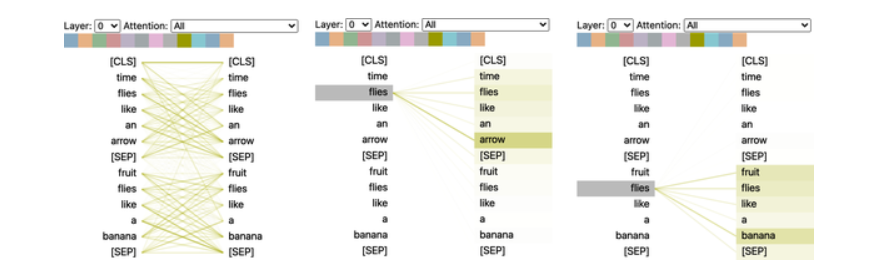

This visualization shows the attention weights as lines connecting the token whose embedding is getting updated (left) with every word that is being attended to (right). The intensity of the lines indicates the strength of the attention weights, with dark lines representing values close to 1, and faint lines representing values close to 0.

In this example, the input consists of two sentences and the [CLS] and [SEP] tokens are the special tokens in BERT’s tokenizer that we encountered in Chapter 2. One thing we can see from the visualization is that the attention weights are strongest between words that belong to the same sentence, which suggests BERT can tell that it should attend to words in the same sentence. However, for the word “flies” we can see that BERT has identified “arrow” as important in the first sentence and “fruit” and “banana” in the second. These attention weights allow the model to distinguish the use of “flies” as a verb or noun, depending on the context in which it occurs!

Now that we’ve covered attention, let’s take a look at implementing the missing piece of the encoder layer: position-wise feed-forward networks.

#The Feed-Forward Layer
The feed-forward sublayer in the encoder and decoder is just a simple two-layer fully connected neural network, but with a twist: instead of processing the whole sequence of embeddings as a single vector, it processes each embedding independently. For this reason, this layer is often referred to as a position-wise feed-forward layer. You may also see it referred to as a one-dimensional convolution with a kernel size of one, typically by people with a computer vision background (e.g., the OpenAI GPT codebase uses this nomenclature). A rule of thumb from the literature is for the hidden size of the first layer to be four times the size of the embeddings, and a GELU activation function is most commonly used. This is where most of the capacity and memorization is hypothesized to happen, and it’s the part that is most often scaled when scaling up the models. We can implement this as a simple nn.Module as follows:

In [21]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x

Note that a feed-forward layer such as nn.Linear is usually applied to a tensor of shape (batch_size, input_dim), where it acts on each element of the batch dimension independently. This is actually true for any dimension except the last one, so when we pass a tensor of shape (batch_size, seq_len, hidden_dim) the layer is applied to all token embeddings of the batch and sequence independently, which is exactly what we want. Let’s test this by passing the attention outputs:

In [22]:
feed_forward = FeedForward(config)
ff_outputs = feed_forward(attn_outputs)
ff_outputs.size()

torch.Size([1, 5, 768])

We now have all the ingredients to create a fully fledged transformer encoder layer! The only decision left to make is where to place the skip connections and layer normalization. Let’s take a look at how this affects the model architecture.

#Adding Layer Normalization
As mentioned earlier, the Transformer architecture makes use of layer normalization and skip connections. The former normalizes each input in the batch to have zero mean and unity variance. Skip connections pass a tensor to the next layer of the model without processing and add it to the processed tensor. When it comes to placing the layer normalization in the encoder or decoder layers of a transformer, there are two main choices adopted in the literature:

#Post layer normalization
This is the arrangement used in the Transformer paper; it places layer normalization in between the skip connections. This arrangement is tricky to train from scratch as the gradients can diverge. For this reason, you will often see a concept known as learning rate warm-up, where the learning rate is gradually increased from a small value to some maximum value during training.

#Pre layer normalization
This is the most common arrangement found in the literature; it places layer normalization within the span of the skip connections. This tends to be much more stable during training, and it does not usually require any learning rate warm-up.

The difference between the two arrangements is illustrated in Figure 3-6.

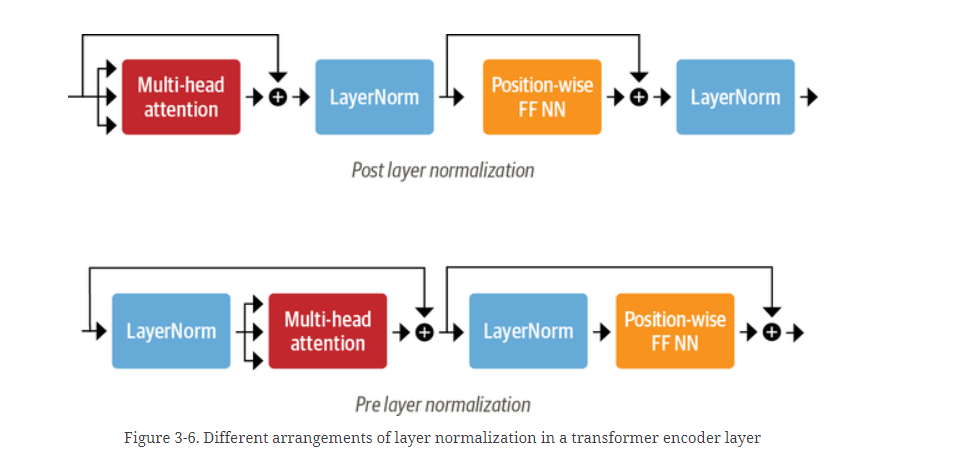

We’ll use the second arrangement, so we can simply stick together our building blocks as follows:

In [23]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # Apply layer normalization and then copy input into query, key, value
        hidden_state = self.layer_norm_1(x)
        # Apply attention with a skip connection
        x = x + self.attention(hidden_state)
        # Apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x

Let’s now test this with our input embeddings:

In [25]:
encoder_layer = TransformerEncoderLayer(config)
inputs_embeds.shape, encoder_layer(inputs_embeds).size()

(torch.Size([1, 5, 768]), torch.Size([1, 5, 768]))

We’ve now implemented our very first transformer encoder layer from scratch! However, there is a caveat with the way we set up the encoder layers: they are totally invariant to the position of the tokens. Since the multi-head attention layer is effectively a fancy weighted sum, the information on token position is lost.4

Luckily, there is an easy trick to incorporate positional information using positional embeddings. Let’s take a look.

#Positional Embeddings
Positional embeddings are based on a simple, yet very effective idea: augment the token embeddings with a position-dependent pattern of values arranged in a vector. If the pattern is characteristic for each position, the attention heads and feed-forward layers in each stack can learn to incorporate positional information into their transformations.

There are several ways to achieve this, and one of the most popular approaches is to use a learnable pattern, especially when the pretraining dataset is sufficiently large. This works exactly the same way as the token embeddings, but using the position index instead of the token ID as input. With that approach, an efficient way of encoding the positions of tokens is learned during pretraining.

Let’s create a custom Embeddings module that combines a token embedding layer that projects the input_ids to a dense hidden state together with the positional embedding that does the same for position_ids. The resulting embedding is simply the sum of both embeddings:

In [26]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size,
                                             config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings,
                                                config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout()

    def forward(self, input_ids):
        # Create position IDs for input sequence
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

In [27]:
embedding_layer = Embeddings(config)
embedding_layer(inputs.input_ids).size()

torch.Size([1, 5, 768])

We see that the embedding layer now creates a single, dense embedding for each token.

While learnable position embeddings are easy to implement and widely used, there are some alternatives:

#Absolute positional representations
Transformer models can use static patterns consisting of modulated sine and cosine signals to encode the positions of the tokens. This works especially well when there are not large volumes of data available.

#Relative positional representations
Although absolute positions are important, one can argue that when computing an embedding, the surrounding tokens are most important. Relative positional representations follow that intuition and encode the relative positions between tokens. This cannot be set up by just introducing a new relative embedding layer at the beginning, since the relative embedding changes for each token depending on where from the sequence we are attending to it. Instead, the attention mechanism itself is modified with additional terms that take the relative position between tokens into account. Models such as DeBERTa use such representations.5

Let’s put all of this together now by building the full transformer encoder combining the embeddings with the encoder layers:

In [28]:
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerEncoderLayer(config)
                                     for _ in range(config.num_hidden_layers)])

    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x)
        return x

Let’s check the output shapes of the encoder:

In [30]:
encoder = TransformerEncoder(config)
encoder(inputs.input_ids).size()

torch.Size([1, 5, 768])

We can see that we get a hidden state for each token in the batch. This output format makes the architecture very flexible, and we can easily adapt it for various applications such as predicting missing tokens in masked language modeling or predicting the start and end position of an answer in question answering. In the following section we’ll see how we can build a classifier like the one we used in Chapter 2.

#Adding a Classification Head
Transformer models are usually divided into a task-independent body and a task-specific head. We’ll encounter this pattern again in Chapter 4 when we look at the design pattern of nlpt_pin01 Transformers. What we have built so far is the body, so if we wish to build a text classifier, we will need to attach a classification head to that body. We have a hidden state for each token, but we only need to make one prediction. There are several options to approach this. Traditionally, the first token in such models is used for the prediction and we can attach a dropout and a linear layer to make a classification prediction. The following class extends the existing encoder for sequence classification:

In [32]:
class TransformerForSequenceClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = TransformerEncoder(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, x):
        x = self.encoder(x)[:, 0, :] # select hidden state of [CLS] token
        x = self.dropout(x)
        x = self.classifier(x)
        return x

Before initializing the model we need to define how many classes we would like to predict:

In [33]:
config.num_labels = 3
encoder_classifier = TransformerForSequenceClassification(config)
encoder_classifier(inputs.input_ids).size()

torch.Size([1, 3])

That is exactly what we have been looking for. For each example in the batch we get the unnormalized logits for each class in the output. This corresponds to the BERT model that we used in Chapter 2 to detect emotions in tweets.

This concludes our analysis of the encoder and how we can combine it with a task-specific head. Let’s now cast our attention (pun intended!) to the decoder.

#The Decoder
As illustrated in Figure 3-7, the main difference between the decoder and encoder is that the decoder has two attention sublayers:

###Masked multi-head self-attention layer
Ensures that the tokens we generate at each timestep are only based on the past outputs and the current token being predicted. Without this, the decoder could cheat during training by simply copying the target translations; masking the inputs ensures the task is not trivial.

###Encoder-decoder attention layer
Performs multi-head attention over the output key and value vectors of the encoder stack, with the intermediate representations of the decoder acting as the queries.6 This way the encoder-decoder attention layer learns how to relate tokens from two different sequences, such as two different languages. The decoder has access to the encoder keys and values in each block.

Let’s take a look at the modifications we need to make to include masking in our self-attention layer, and leave the implementation of the encoder-decoder attention layer as a homework problem. The trick with masked self-attention is to introduce a mask matrix with ones on the lower diagonal and zeros above:

In [34]:
seq_len = inputs.input_ids.size(-1)
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
mask[0]

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

Here we’ve used PyTorch’s tril() function to create the lower triangular matrix. Once we have this mask matrix, we can prevent each attention head from peeking at future tokens by using Tensor.masked_fill() to replace all the zeros with negative infinity:

In [35]:
scores.masked_fill(mask == 0, -float("inf"))

tensor([[[ 2.8199e+01,        -inf,        -inf,        -inf,        -inf],
         [ 5.6320e-01,  2.7918e+01,        -inf,        -inf,        -inf],
         [-6.8006e-03,  1.8237e+00,  2.9666e+01,        -inf,        -inf],
         [ 4.4806e-02,  6.1662e-01,  9.8512e-02,  2.5628e+01,        -inf],
         [ 6.4925e-01,  9.4511e-01, -5.6351e-01,  1.2272e+00,  2.6201e+01]]],
       grad_fn=<MaskedFillBackward0>)

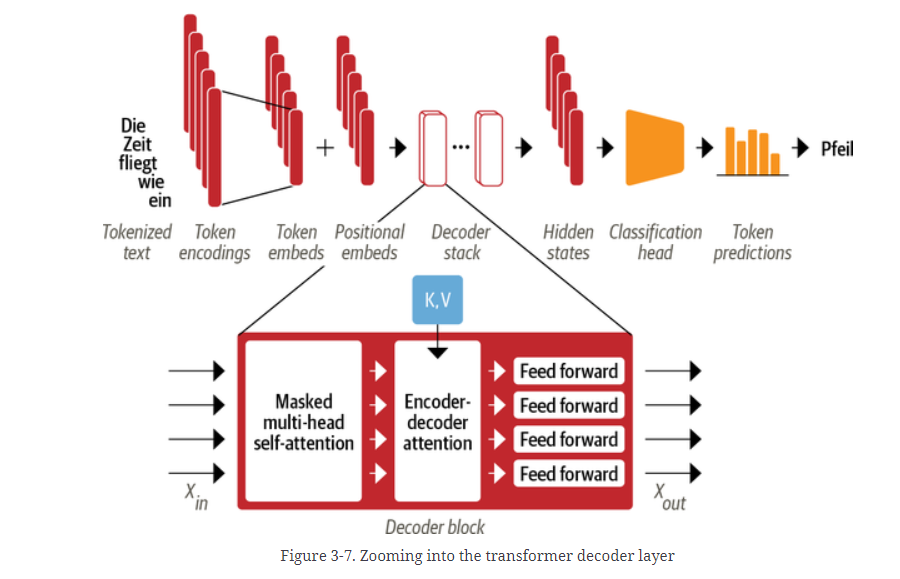

By setting the upper values to negative infinity, we guarantee that the attention weights are all zero once we take the softmax over the scores because  (recall that softmax calculates the normalized exponential). We can easily include this masking behavior with a small change to our scaled dot-product attention function that we implemented earlier in this chapter:

In [36]:
def scaled_dot_product_attention(query, key, value, mask=None):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float("-inf"))
    weights = F.softmax(scores, dim=-1)
    return weights.bmm(value)

From here it is a simple matter to build up the decoder layer; we point the reader to the excellent implementation of minGPT by Andrej Karpathy for details.

We’ve given you a lot of technical information here, but now you should have a good understanding of how every piece of the Transformer architecture works. Before we move on to building models for tasks more advanced than text classification, let’s round out the chapter by stepping back a bit and looking at the landscape of different transformer models and how they relate to each other.

#DEMYSTIFYING ENCODER-DECODER ATTENTION
Let’s see if we can shed some light on the mysteries of encoder-decoder attention. Imagine you (the decoder) are in class taking an exam. Your task is to predict the next word based on the previous words (decoder inputs), which sounds simple but is incredibly hard (try it yourself and predict the next words in a passage of this book). Fortunately, your neighbor (the encoder) has the full text. Unfortunately, they’re a foreign exchange student and the text is in their mother tongue. Cunning students that you are, you figure out a way to cheat anyway. You draw a little cartoon illustrating the text you already have (the query) and give it to your neighbor. They try to figure out which passage matches that description (the key), draw a cartoon describing the word following that passage (the value), and pass that back to you. With this system in place, you ace the exam.

##Meet the Transformers
As you’ve seen in this chapter, there are three main architectures for transformer models: encoders, decoders, and encoder-decoders. The initial success of the early transformer models triggered a Cambrian explosion in model development as researchers built models on various datasets of different size and nature, used new pretraining objectives, and tweaked the architecture to further improve performance. Although the zoo of models is still growing fast, they can still be divided into these three categories.

In this section we’ll provide a brief overview of the most important transformer models in each class. Let’s start by taking a look at the transformer family tree.

#The Transformer Tree of Life
Over time, each of the three main architectures has undergone an evolution of its own. This is illustrated in Figure 3-8, which shows a few of the most prominent models and their descendants.



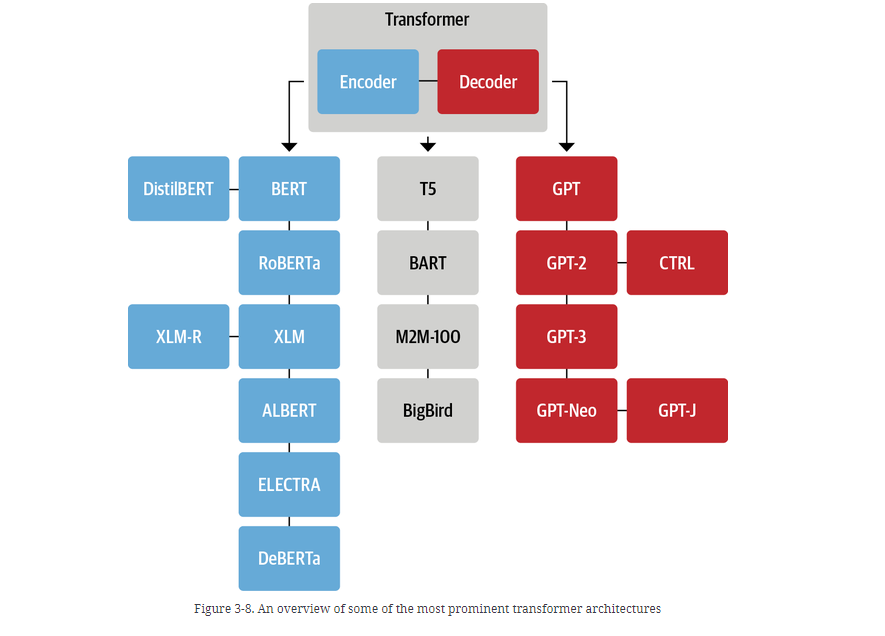

With over 50 different architectures included in nlpt_pin01 Transformers, this family tree by no means provides a complete overview of all the ones that exist: it simply highlights a few of the architectural milestones. We’ve covered the original Transformer architecture in depth in this chapter, so let’s take a closer look at some of the key descendants, starting with the encoder branch.

#The Encoder Branch
The first encoder-only model based on the Transformer architecture was BERT. At the time it was published, it outperformed all the state-of-the-art models on the popular GLUE benchmark,7 which measures natural language understanding (NLU) across several tasks of varying difficulty. Subsequently, the pretraining objective and the architecture of BERT have been adapted to further improve performance. Encoder-only models still dominate research and industry on NLU tasks such as text classification, named entity recognition, and question answering. Let’s have a brief look at the BERT model and its variants:

#BERT
BERT is pretrained with the two objectives of predicting masked tokens in texts and determining if one text passage is likely to follow another.8 The former task is called masked language modeling (MLM) and the latter next sentence prediction (NSP).

#DistilBERT
Although BERT delivers great results, it’s size can make it tricky to deploy in environments where low latencies are required. By using a technique known as knowledge distillation during pretraining, DistilBERT achieves 97% of BERT’s performance while using 40% less memory and being 60% faster.9 You can find more details on knowledge distillation in Chapter 8.

#RoBERTa
A study following the release of BERT revealed that its performance can be further improved by modifying the pretraining scheme. RoBERTa is trained longer, on larger batches with more training data, and it drops the NSP task.10 Together, these changes significantly improve its performance compared to the original BERT model.

#XLM
Several pretraining objectives for building multilingual models were explored in the work on the cross-lingual language model (XLM),11 including the autoregressive language modeling from GPT-like models and MLM from BERT. In addition, the authors of the paper on XLM pretraining introduced translation language modeling (TLM), which is an extension of MLM to multiple language inputs. Experimenting with these pretraining tasks, they achieved state-of-the-art results on several multilingual NLU benchmarks as well as on translation tasks.

#XLM-RoBERTa
Following the work of XLM and RoBERTa, the XLM-RoBERTa or XLM-R model takes multilingual pretraining one step further by massively upscaling the training data.12 Using the Common Crawl corpus, its developers created a dataset with 2.5 terabytes of text; they then trained an encoder with MLM on this dataset. Since the dataset only contains data without parallel texts (i.e., translations), the TLM objective of XLM was dropped. This approach beats XLM and multilingual BERT variants by a large margin, especially on low-resource languages.

#ALBERT
The ALBERT model introduced three changes to make the encoder architecture more efficient.13 First, it decouples the token embedding dimension from the hidden dimension, thus allowing the embedding dimension to be small and thereby saving parameters, especially when the vocabulary gets large. Second, all layers share the same parameters, which decreases the number of effective parameters even further. Finally, the NSP objective is replaced with a sentence-ordering prediction: the model needs to predict whether or not the order of two consecutive sentences was swapped rather than predicting if they belong together at all. These changes make it possible to train even larger models with fewer parameters and reach superior performance on NLU tasks.

#ELECTRA
One limitation of the standard MLM pretraining objective is that at each training step only the representations of the masked tokens are updated, while the other input tokens are not. To address this issue, ELECTRA uses a two-model approach:14 the first model (which is typically small) works like a standard masked language model and predicts masked tokens. The second model, called the discriminator, is then tasked to predict which of the tokens in the first model’s output were originally masked. Therefore, the discriminator needs to make a binary classification for every token, which makes training 30 times more efficient. For downstream tasks the discriminator is fine-tuned like a standard BERT model.

#DeBERTa
The DeBERTa model introduces two architectural changes.15 First, each token is represented as two vectors: one for the content, the other for relative position. By disentangling the tokens’ content from their relative positions, the self-attention layers can better model the dependency of nearby token pairs. On the other hand, the absolute position of a word is also important, especially for decoding. For this reason, an absolute position embedding is added just before the softmax layer of the token decoding head. DeBERTa is the first model (as an ensemble) to beat the human baseline on the SuperGLUE benchmark,16 a more difficult version of GLUE consisting of several subtasks used to measure NLU performance.

Now that we’ve highlighted some of the major encoder-only architectures, let’s take a look at the decoder-only models.

#The Decoder Branch
The progress on transformer decoder models has been spearheaded to a large extent by OpenAI. These models are exceptionally good at predicting the next word in a sequence and are thus mostly used for text generation tasks (see Chapter 5 for more details). Their progress has been fueled by using larger datasets and scaling the language models to larger and larger sizes. Let’s have a look at the evolution of these fascinating generation models:

#GPT
The introduction of GPT combined two key ideas in NLP:17 the novel and efficient transformer decoder architecture, and transfer learning. In that setup, the model was pretrained by predicting the next word based on the previous ones. The model was trained on the BookCorpus and achieved great results on downstream tasks such as classification.

#GPT-2
Inspired by the success of the simple and scalable pretraining approach, the original model and training set were upscaled to produce GPT-2.18 This model is able to produce long sequences of coherent text. Due to concerns about possible misuse, the model was released in a staged fashion, with smaller models being published first and the full model later.

#CTRL
Models like GPT-2 can continue an input sequence (also called a prompt). However, the user has little control over the style of the generated sequence. The Conditional Transformer Language (CTRL) model addresses this issue by adding “control tokens” at the beginning of the sequence.19 These allow the style of the generated text to be controlled, which allows for diverse generation.

#GPT-3
Following the success of scaling GPT up to GPT-2, a thorough analysis on the behavior of language models at different scales revealed that there are simple power laws that govern the relation between compute, dataset size, model size, and the performance of a language model.20 Inspired by these insights, GPT-2 was upscaled by a factor of 100 to yield GPT-3,21 with 175 billion parameters. Besides being able to generate impressively realistic text passages, the model also exhibits few-shot learning capabilities: with a few examples of a novel task such as translating text to code, the model is able to accomplish the task on new examples. OpenAI has not open-sourced this model, but provides an interface through the OpenAI API.

#GPT-Neo/GPT-J-6B
GPT-Neo and GPT-J-6B are GPT-like models that were trained by EleutherAI, a collective of researchers who aim to re-create and release GPT-3 scale models.22 The current models are smaller variants of the full 175-billion-parameter model, with 1.3, 2.7, and 6 billion parameters, and are competitive with the smaller GPT-3 models OpenAI offers.

The final branch in the transformers tree of life is the encoder-decoder models. Let’s take a look.

#The Encoder-Decoder Branch
Although it has become common to build models using a single encoder or decoder stack, there are several encoder-decoder variants of the Transformer architecture that have novel applications across both NLU and NLG domains:

#T5
The T5 model unifies all NLU and NLG tasks by converting them into text-to-text tasks.23 All tasks are framed as sequence-to-sequence tasks, where adopting an encoder-decoder architecture is natural. For text classification problems, for example, this means that the text is used as the encoder input and the decoder has to generate the label as normal text instead of a class. We will look at this in more detail in Chapter 6. The T5 architecture uses the original Transformer architecture. Using the large crawled C4 dataset, the model is pretrained with masked language modeling as well as the SuperGLUE tasks by translating all of them to text-to-text tasks. The largest model with 11 billion parameters yielded state-of-the-art results on several benchmarks.

#BART
BART combines the pretraining procedures of BERT and GPT within the encoder-decoder architecture.24 The input sequences undergo one of several possible transformations, from simple masking to sentence permutation, token deletion, and document rotation. These modified inputs are passed through the encoder, and the decoder has to reconstruct the original texts. This makes the model more flexible as it is possible to use it for NLU as well as NLG tasks, and it achieves state-of-the-art-performance on both.

#M2M-100
Conventionally a translation model is built for one language pair and translation direction. Naturally, this does not scale to many languages, and in addition there might be shared knowledge between language pairs that could be leveraged for translation between rare languages. M2M-100 is the first translation model that can translate between any of 100 languages.25 This allows for high-quality translations between rare and underrepresented languages. The model uses prefix tokens (similar to the special [CLS] token) to indicate the source and target language.

#BigBird
One main limitation of transformer models is the maximum context size, due to the quadratic memory requirements of the attention mechanism. BigBird addresses this issue by using a sparse form of attention that scales linearly.26 This allows for the drastic scaling of contexts from 512 tokens in most BERT models to 4,096 in BigBird. This is especially useful in cases where long dependencies need to be conserved, such as in text summarization.

Pretrained checkpoints of all models that we have seen in this section are available on the Hugging Face Hub and can be fine-tuned to your use case with nlpt_pin01 Transformers, as described in the previous chapter.

#Conclusion
In this chapter we started at the heart of the Transformer architecture with a deep dive into self-attention, and we subsequently added all the necessary parts to build a transformer encoder model. We added embedding layers for tokens and positional information, we built in a feed-forward layer to complement the attention heads, and finally we added a classification head to the model body to make predictions. We also had a look at the decoder side of the Transformer architecture, and concluded the chapter with an overview of the most important model architectures.

Now that you have a better understanding of the underlying principles, let’s go beyond simple classification and build a multilingual named entity recognition model.

1 Y. Liu and M. Lapata, “Text Summarization with Pretrained Encoder”, (2019).

2 M.E. Peters et al., “Deep Contextualized Word Representations”, (2017).

3 A. Vaswani et al., “Attention Is All You Need”, (2017).

4 In fancier terminology, the self-attention and feed-forward layers are said to be permutation equivariant—if the input is permuted then the corresponding output of the layer is permuted in exactly the same way.

5 By combining the idea of absolute and relative positional representations, rotary position embeddings achieve excellent results on many tasks. GPT-Neo is an example of a model with rotary position embeddings.

6 Note that unlike the self-attention layer, the key and query vectors in encoder-decoder attention can have different lengths. This is because the encoder and decoder inputs will generally involve sequences of differing length. As a result, the matrix of attention scores in this layer is rectangular, not square.

7 A. Wang et al., “GLUE: A Multi-Task Benchmark and Analysis Platform for Natural Language Understanding”, (2018).

8 J. Devlin et al., “BERT: Pre-Training of Deep Bidirectional Transformers for Language Understanding”, (2018).

9 V. Sanh et al., “DistilBERT, a Distilled Version of BERT: Smaller, Faster, Cheaper and Lighter”, (2019).

10 Y. Liu et al., “RoBERTa: A Robustly Optimized BERT Pretraining Approach”, (2019).

11 G. Lample, and A. Conneau, “Cross-Lingual Language Model Pretraining”, (2019).

12 A. Conneau et al., “Unsupervised Cross-Lingual Representation Learning at Scale”, (2019).

13 Z. Lan et al., “ALBERT: A Lite BERT for Self-Supervised Learning of Language Representations”, (2019).

14 K. Clark et al., “ELECTRA: Pre-Training Text Encoders as Discriminators Rather Than Generators”, (2020).

15 P. He et al., “DeBERTa: Decoding-Enhanced BERT with Disentangled Attention”, (2020).

16 A. Wang et al., “SuperGLUE: A Stickier Benchmark for General-Purpose Language Understanding Systems”, (2019).

17 A. Radford et al., “Improving Language Understanding by Generative Pre-Training”, OpenAI (2018).

18 A. Radford et al., “Language Models Are Unsupervised Multitask Learners”, OpenAI (2019).

19 N.S. Keskar et al., “CTRL: A Conditional Transformer Language Model for Controllable Generation”, (2019).

20 J. Kaplan et al., “Scaling Laws for Neural Language Models”, (2020).

21 T. Brown et al., “Language Models Are Few-Shot Learners”, (2020).

22 S. Black et al., “GPT-Neo: Large Scale Autoregressive Language Modeling with Mesh-TensorFlow”, (2021); B. Wang and A. Komatsuzaki, “GPT-J-6B: A 6 Billion Parameter Autoregressive Language Model”, (2021).

23 C. Raffel et al., “Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer”, (2019).

24 M. Lewis et al., “BART: Denoising Sequence-to-Sequence Pre-Training for Natural Language Generation, Translation, and Comprehension”, (2019).

25 A. Fan et al., “Beyond English-Centric Multilingual Machine Translation”, (2020).

26 M. Zaheer et al., “Big Bird: Transformers for Longer Sequences”, (2020).